In [22]:

import torch
import torchaudio
from IPython.display import Audio, display
from glob import glob
import math
import os

import matplotlib.pyplot as plt
import requests
import torchaudio
import torch

In [26]:
def plot_waveform(waveform, sample_rate=16000, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

def print_stats(waveform, sample_rate=16000, src=None):
    if src:
        print("-"*10)
        print(f"Source: {src}")
        print("-"*10)
    if sample_rate:
        print(f"Sample Rate: {sample_rate}")
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [145]:

from audio_tools2  import *
def calc_vad(f, verbose=False):
    test_file=f
    fs,s = read_wav(test_file)
    win_len = int(fs*0.025)
    hop_len = int(fs*0.010)
    sframes = audio_tools2.enframe(s,win_len,hop_len) # rows: frame index, cols: each frame
    if verbose:
        plot_this(compute_log_nrg(sframes))

    # percent_high_nrg is the VAD context ratio. It helps smooth the
    # output VAD decisions. Higher values are more strict.
    percent_high_nrg = 0.5

    vad = nrg_vad(sframes,percent_high_nrg)

    if verbose:
        plot_these(deframe(vad,win_len,hop_len),s)
    return deframe(vad,win_len,hop_len) 

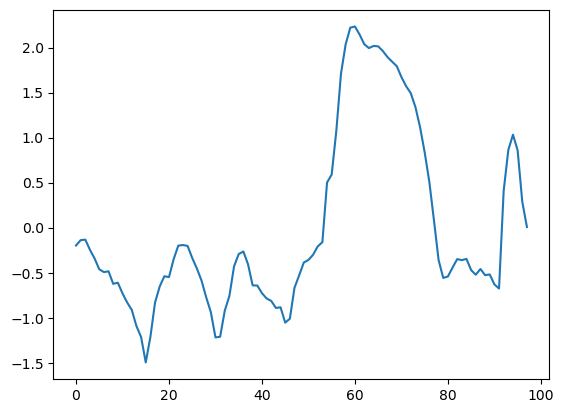

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


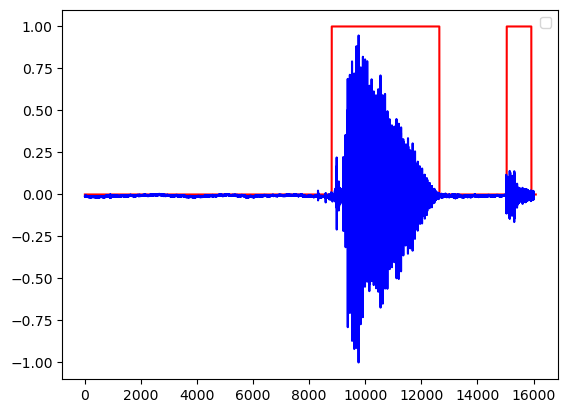

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [146]:
calc_vad(f, True)

In [2]:


filenames = glob(f'/data/ephraim/datasets/sc09/wavs/*.wav')


In [4]:
f = filenames[0]

In [156]:
vaded_signal = calc_vad(f)[0:noisy_signal_.shape[1],:]
vaded_signal_torch = (noisy_signal_[0][vaded_signal.T[0]>0])
vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
vaded_signal_torch.shape

torch.Size([1, 4720])

In [149]:
vaded_signal_torch

tensor([-0.0070, -0.0084, -0.0071,  ...,  0.0031, -0.0055, -0.0109])

In [7]:

noisy_signal_, sr =torchaudio.load(f)
power_x0_a = float(1 / noisy_signal_.shape[1] * torch.sum(noisy_signal_**2))
power_x0_a

0.0006341795669868588

In [157]:
power_x0_b =  1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2)
power_x0_b

tensor(0.0021)

In [159]:
simple_power = np.zeros(len(filenames))
clean_power = np.zeros(len(filenames))
for i,f in enumerate(filenames):
    noisy_signal_, sr =torchaudio.load(f)
    vaded_signal = calc_vad(f)[0:noisy_signal_.shape[1],:]
    vaded_signal_torch = (noisy_signal_[0][vaded_signal.T[0]>0])
    vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
    power_x0_a = float(1 / noisy_signal_.shape[1] * torch.sum(noisy_signal_**2))
    simple_power[i] = power_x0_a
    try:
        power_x0_b =  1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2)
    except:
        power_x0_b=0
    clean_power[i] = power_x0_b


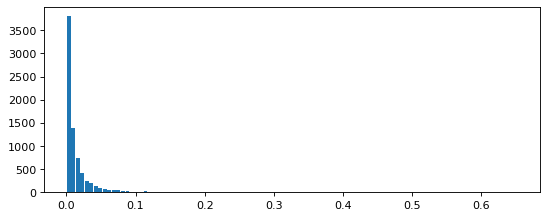

In [180]:
from matplotlib.pyplot import figure

figure(figsize=(8, 3), dpi=80)
n, bins, patches = plt.hist(x=clean_power,bins=100, rwidth=0.85)

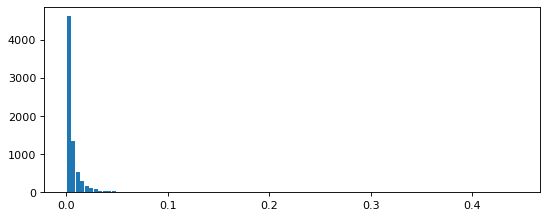

In [181]:
figure(figsize=(8, 3), dpi=80)
n, bins, patches = plt.hist(x=simple_power,bins=100, rwidth=0.85)

In [184]:
import pandas as pd
df_describe = pd.DataFrame(clean_power)
df_describe.describe()

,0
count,7398.000000
mean,0.015434
std,0.034641
min,0.000000
25%,0.001750
50%,0.006146
75%,0.015587
max,0.653375


In [185]:
import pandas as pd
df_describe = pd.DataFrame(simple_power)
df_describe.describe()

,0
count,7398.000000
mean,0.006896
std,0.016384
min,0.000028
25%,0.000735
50%,0.002720
75%,0.007065
max,0.445415


In [190]:
0.034641/0.015434


2.244460282493197

In [188]:
sum(clean_power==0)

1

In [35]:
print(len(noisy_signal_[0]))
(noisy_signal_[noisy_signal_>0.01]).shape

16000


torch.Size([1141])

In [13]:
display(Audio(noisy_signal_, rate=sr, autoplay=False))

In [155]:
x

tensor([[-0.0070, -0.0084, -0.0071,  ...,  0.0031, -0.0055, -0.0109]])

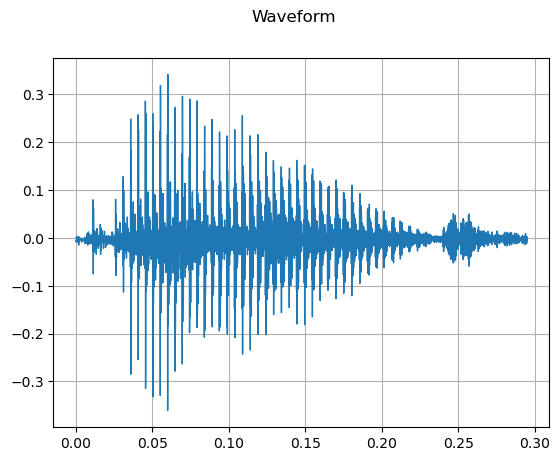

In [154]:
x = torch.unsqueeze(vaded_signal_torch, dim=0)
plot_waveform(x)

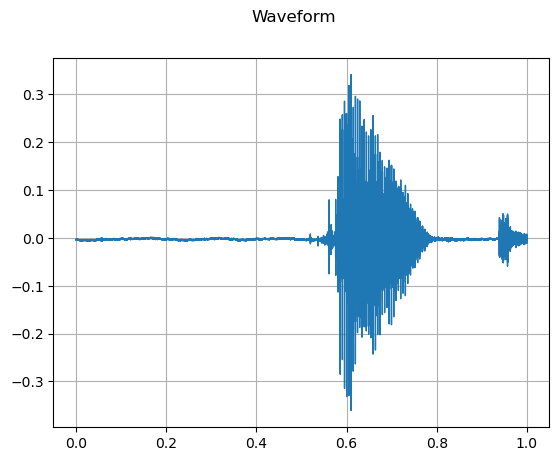

In [27]:
plot_waveform(noisy_signal_)

Sample Rate: 16000
Dtype: torch.float32
 - Max:      0.341
 - Min:     -0.361
 - Mean:    -0.003
 - Std Dev:  0.025

tensor([[-0.0035, -0.0028, -0.0039,  ...,  0.0037,  0.0023, -0.0063]])



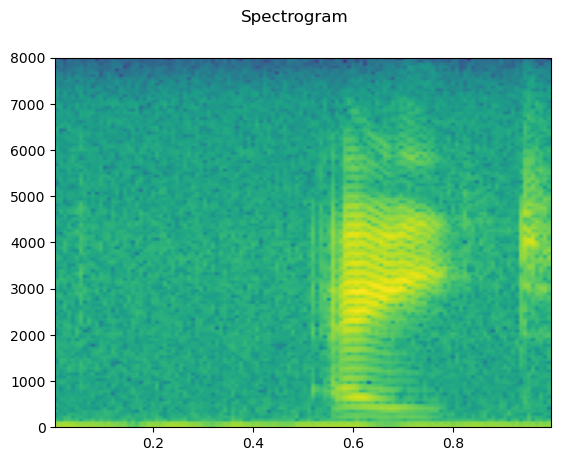

In [28]:

print_stats(noisy_signal_)

plot_specgram(noisy_signal_, 16000)

In [18]:
from scipy.io.wavfile import read
input_data = read(f)
audio = input_data[1]

In [21]:
max(audio)

11187

In [20]:
torch.max(noisy_signal_)

tensor(0.3414)

In [1]:
import json
with open("power_stats_5min.json") as f:
    d= json.load(f)

In [3]:
sample = d["samples"]


In [8]:
import pandas as pd
df = pd.DataFrame(sample)

In [11]:
df.describe()

,simple_power,clean_power
count,120.000000,120.000000
mean,0.014746,0.029344
std,0.007106,0.013666
min,0.005079,0.012693
25%,0.009647,0.019668
50%,0.012863,0.025652
75%,0.017631,0.034643
max,0.045431,0.083208


In [12]:
print(0.007106/0.014746)
print(0.013666/0.029344)

0.48189339481893395
0.465717011995638


In [2]:
import pandas as pd

import json
with open("power_stats.json") as f:
    d= json.load(f)
sample2 = d["samples"]
df2 = pd.DataFrame(sample2)
df2.describe()

,simple_power,clean_power
count,100.000000,100.000000
mean,0.013460,0.030451
std,0.019596,0.044710
min,0.000021,0.000030
25%,0.002587,0.005545
50%,0.007787,0.016293
75%,0.014438,0.033422
max,0.114814,0.265932
